In [34]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

# Configure pytesseract path to the location where tesseract.exe is installed
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'  # Update the path based on your installation


def preprocess_image(image_path):
    """Load an image, convert to grayscale, and apply adaptive thresholding."""
    image = cv2.imread(image_path)
    # gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    
    ret,processed_image = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
    # processed_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    processed_image = cv2.bitwise_not(processed_image)
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 1, 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')

    return processed_image

def extract_sudoku_grid(image):
    """Extract Sudoku grid from the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]
    perimeter = cv2.arcLength(largest_contour, True)
    roi = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)
    return roi

def get_perspective_transform(image, corners):
    """Apply perspective transform to the grid."""
    corners = sorted(np.concatenate(corners).tolist())
    top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[-1], corners[2]
    side = max([
        np.linalg.norm(np.subtract(top_left, top_right)),
        np.linalg.norm(np.subtract(top_right, bottom_right)),
        np.linalg.norm(np.subtract(bottom_right, bottom_left)),
        np.linalg.norm(np.subtract(bottom_left, top_left))
    ])
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    transformed_image = cv2.warpPerspective(image, m, (int(side), int(side)))
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title('Transfromed Image')
    plt.axis('off')
    plt.show()
    return cv2.warpPerspective(image, m, (int(side), int(side)))

def extract_digits(transformed_image):
    """Extract digits from each cell of the Sudoku grid."""
    grid_size = transformed_image.shape[0] // 9
    print("Grid Size:" + str(grid_size))
    transformed_image = cv2.bitwise_not(transformed_image)
    
    grid = []
    for y in range(9):
        row = []
        for x in range(9):
            clipping = 0
            x1 = x * grid_size + clipping
            y1 = y * grid_size + clipping
            x2 = x1 + grid_size - clipping
            y2 = y1 + grid_size - clipping

            cell = transformed_image[y1+4:y2-4, x1+4:x2-4]

            # Grayscale, Gaussian blur, Otsu's threshold
            # image = cv2.imread('1.png')
            # gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(cell, (5,5), 0)
            thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            # invert = 255 - opening
            cellImg = opening

            if x == 3 and y == 0:
                plt.figure(figsize=(1, 1))
                plt.imshow(cellImg, cmap='gray')
                plt.title('Cell Image (3, 0)')
                plt.axis('off')
                plt.show()

            if x == 0 and y == 3:
                plt.figure(figsize=(1,1))
                plt.imshow(cellImg, cmap='gray')
                plt.title('Cell Image (0, 3)')
                plt.axis('off')
                plt.show()

            # digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789')
            # digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3')
            digit = pytesseract.image_to_string(cellImg, lang='eng', config='--psm 6')
            print("Value in ["+str(x)+","+str(y)+"]:" + str(digit.strip()))
            try:
                row.append(str(digit.strip()))
                row.append(int(digit.strip()))
            except ValueError as ve:
                print(type(ve), ve)
                row.append(0)  # Assuming empty cell if OCR fails to recognize a digit
                print("error")
        grid.append(row)
    return grid

def apply_opening_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
 
    kernel_size = 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(opened_image, cmap='gray')
    plt.title('Binary Open Filter Image')
    plt.axis('off')
    plt.show()
    # cv2.imwrite('opened_image.jpg', opened_image)
    # cv2.imshow('Original', binary_image)
    # cv2.imshow('Opened', opened_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

def apply_close_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.bitwise_not(image)
    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Define the kernel size for the morphological operation
    kernel_size = 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    # closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    
    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(closed_image, cmap='gray')
    plt.title('Binary Closed Filter Image')
    plt.axis('off')
    plt.show()

def rotate_image(image, angle):
    """
    Rotate the image by the given angle in degrees.

    Parameters:
    - image: Input image as a numpy array (loaded via cv2.imread or similar).
    - angle: Float. The angle to rotate the image, in degrees. Positive values rotate
             the image counterclockwise, and negative values rotate it clockwise.

    Returns:
    - Rotated image as a numpy array.
    """
    # Get the image dimensions (height, width)
    height, width = image.shape[:2]
    
    # Compute the center of the image from which to rotate
    center = (width / 2, height / 2)
    
    # Get the rotation matrix using cv2.getRotationMatrix2D
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Determine the bounding box of the new image after the rotation (to avoid clipping)
    cos_val = np.abs(rotation_matrix[0, 0])
    sin_val = np.abs(rotation_matrix[0, 1])
    
    # Compute the new dimensions of the image
    new_width = int((height * sin_val) + (width * cos_val))
    new_height = int((height * cos_val) + (width * sin_val))
    
    # Adjust the rotation matrix to account for translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Perform the actual rotation and return the image
    return cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

def box_outline_text(image):
    # img = cv2.imread('image.png')
    h, w = image.shape
    boxes = pytesseract.image_to_boxes(image) 
    for b in boxes.splitlines():
        b = b.split(' ')
        image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

    # cv2.imshow('img', img)
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.title('Image 2 text OCR')
    plt.axis('off')
    plt.show()

def transform_image(image, angle, flip_horizontally=False, flip_vertically=False):
    """
    Rotate and possibly flip an image.

    Parameters:
    - image: Input image as a numpy array (loaded via cv2.imread or similar).
    - angle: Float. The angle to rotate the image, in degrees. Positive values rotate
             the image counterclockwise, and negative values rotate it clockwise.
    - flip_horizontally: Boolean. If True, the image will be flipped horizontally.
    - flip_vertically: Boolean. If True, the image will be flipped vertically.

    Returns:
    - Transformed image as a numpy array.
    """
    # Get the image dimensions (height, width)
    height, width = image.shape[:2]
    
    # Compute the center of the image from which to rotate
    center = (width / 2, height / 2)
    
    # Get the rotation matrix using cv2.getRotationMatrix2D
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Determine the bounding box of the new image after the rotation (to avoid clipping)
    cos_val = np.abs(rotation_matrix[0, 0])
    sin_val = np.abs(rotation_matrix[0, 1])
    
    # Compute the new dimensions of the image
    new_width = int((height * sin_val) + (width * cos_val))
    new_height = int((height * cos_val) + (width * sin_val))
    
    # Adjust the rotation matrix to account for translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Perform the actual rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

    # Flip the image if required
    if flip_horizontally:
        rotated_image = cv2.flip(rotated_image, 1)  # flip horizontally
    if flip_vertically:
        rotated_image = cv2.flip(rotated_image, 0)  # flip vertically

    plt.figure(figsize=(6, 6))
    plt.imshow(rotated_image, cmap='gray')
    plt.title('Binary Open Filter Image')
    plt.axis('off')
    plt.show()

    return rotated_image

def main(image_path):
    processed_image = preprocess_image(image_path)
    roi = extract_sudoku_grid(processed_image)
    transformed_image = get_perspective_transform(processed_image, roi)
    rotated_image = rotate_image(transformed_image, -90)
    transformed_image = transform_image(rotated_image, 0, flip_horizontally=True, flip_vertically=False)
    # apply_opening_filter(rotated_image)
    # apply_close_filter(rotated_image)
    # box_outline_text(rotated_image)
    sudoku_grid = extract_digits(transformed_image)
    # sudoku_grid = extract_digits(transformed_image)
    return sudoku_grid

# Example Usage
sudoku_grid = main(".//Image_015.png")
print(np.array(sudoku_grid))


SyntaxError: '(' was never closed (1523329377.py, line 112)

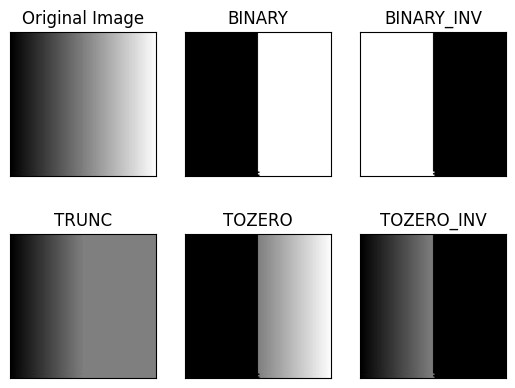

In [61]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
 
img = cv.imread('gradient.png', cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
 
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
 
for i in range(6):
 plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
 plt.title(titles[i])
 plt.xticks([]),plt.yticks([])
 
plt.show()


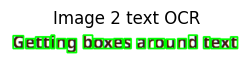

In [3]:
import cv2
import pytesseract
import matplotlib.pyplot as plt

img = cv2.imread('image.png')

h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# cv2.imshow('img', img)
plt.figure(figsize=(3, 3))
plt.imshow(img, cmap='gray')
plt.title('Image 2 text OCR')
plt.axis('off')
plt.show()

In [12]:
import cv2
import pytesseract

# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe' 

# Grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('1.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise and invert image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
invert = 255 - opening

# Perform text extraction
data = pytesseract.image_to_string(invert, lang='eng', config='--psm 6')
print(data)

cv2.imshow('thresh', thresh)
cv2.imshow('opening', opening)
cv2.imshow('invert', invert)
# cv2.waitKey()

ZHHH


